# Instalando bibliotecas

In [38]:
""" Installing libraries """
%pip install --quiet pandas==2.3.2 matplotlib==3.10.6 seaborn==0.13.2 scikit-learn==1.7.1 numpy==2.2.6 pyarrow==21.0.0
%pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Importando bibliotecas (externas e próprias)

In [39]:
""" Importing libraries """

import sys
import os

# Add the parent directory to sys.path so 'Modules' can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Our modules
from Modules.evaluation.output_formatter import forecast_to_output
from Modules.loading.plug_n_play import get_clean_data
from Modules.loading.read_parquet import read_parquet_file 
from Modules.models.forecast import forecast_blind
from Modules.models.make_dataset import SingleSeriesDataset, MultiSeriesDataset
from Modules.models.NBeats import NBeatsBlock, NBeats
from Modules.models.test import hard_test
from Modules.models.test import soft_test
from Modules.models.training import train_model
from Modules.models.WMAPELoss import WMAPELoss
from Modules.preprocessing.onehot import one_hot_encode_parquet


# Definição dos hiper-parâmetros

In [37]:
""" Defining hyper-parameters """

HYPERPARAMS = {
    # Neural Network Global Parameters
    'input_size': 30,       # Number of past days to use as input
    'output_size': 7,       # Number of future days to predict
    'batch_size': 28,       # Batch size for training
    'n_layers': 4,          # Number of layers in the N-BEATS model
    'hidden_size': 128,     # Number of hidden units in each layer

    # Training parameters
    'learning_rate': 1e-3,  # Learning rate for the optimizer
    'epochs': 10,          # Number of training epochs (iterations over the entire dataset)
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # Use GPU if available
    'blind_horizon': 4,     # Number of days to exclude from the end of the training set for hard test
    'split': 1,             # Proportion of data to use for training (1.0 for validation)
    'seed': 42,             # Random seed for reproducibility
}

# Importação do Dataset

É interessante dividir o treino em batches (mini-conjuntos de treino). Cada batch possui o tamanho de input size, seguindo a ordem cronológica de vendas dentro daquela janela de dias. No entanto, durante o treinamento é **ESSENCIAL** que a escolha do próximo batch seja aleatória.

Ex.: Inicia o treino por 21-27 jul e prevê 28, depois pula para 02-08 fev para prever 03. Esse processo deve ser repetido até todos os dados serem treinados, finalizando **01 epoch**.

O número de **epochs** diz o número total de iterações do modelo com relação ao dataset inteiro.

Sobre a composição da janela de input dentro de um batch, existem duas abordagens:

1) Treinar em cada janela todas as séries (pense que cada par produto-loja x tempo representa uma série temporal dentro daquele período). Esse modelo é bem mais complexo pois o output deve ter o mesmo tamanho de produto-loja.
2) Treinar vários modelos separados (considerando uma série temporal para cada modelo). Esse método é ineficiente pois o modelo nunca irá aprender os padrões entre as séries.
3) Treinar o modelo com um par produto-loja por vez. Ou seja:
   - O modelo realiza epochs = N iterações de treino ao longo de todo dataset
     - Em cada epoch, passa por todas as M batches
       - Em cada batch (que possui uma janela de tamanho input_size), atualiza os parâmetros para cada série temporal ($x_l,y_l$). Totalizando L atualizações, com L sendo o número de pares produto-loja.

Ressalta-se que cada conjunto ($x_l,y_l$) representa:
- $x_l$: série temporal do l-ésimo par produto-loja, sendo um vetor de tamanho input_size x (features + 1)
- $y_l$: Previsão de vendas do l-ésimo par produto-loja para os próximos $output_size$ dias


In [40]:
""" get dataset function """

def get_dataset(sample, feature, hyperparams):
    input_size = hyperparams['input_size']
    output_size = hyperparams['output_size']

    # Inicializando os vetores de entrada e os rótulos
    X = []
    y = []

    # Número total de amostras (janelas diferentes) que podem ser extraídas
    # de um mesmo sample
    num_windows = len(sample) - input_size - output_size + 1
    print(f"Número total de janelas extraídas: {num_windows}")
    print(f"Para janelas de tamanho {input_size} e previsão de {output_size} dias à frente.")
    # Extraindo janelas deslizantes
    for i in range(num_windows):

        X_window = sample[i:i+input_size]             # janela de entrada
        feature_window = feature[i:i+input_size]      # janela de entrada

        X_window = np.stack([X_window,feature_window], axis=1)  # shape = (input_size, 4)

        y_window = sample[i+input_size:i+input_size+output_size]  # próximos dias da série

        X.append(X_window)
        y.append(y_window)

    # Convertendo para arrays numpy e depois para tensores PyTorch
    X = np.array(X)  # shape = [num_windows, input_size, num_features]
    y = np.array(y)  # shape = [num_windows, output_size]
    print()
    print("O vetor de entrada  antes do flatten")
    print(f"tem shape (num_windows, size_window, num_features): {X.shape}")

    X = torch.tensor(X, dtype=torch.float32)  # shape = [n_samples, input_size, 1]

    y = torch.tensor(y, dtype=torch.float32)  # shape = [n_samples, 1]


    dataset_full = SingleSeriesDataset(X, y)
    return dataset_full, X, y


In [41]:
""" Training Model """

def traininig_func(X_train, y_train, num_features, hyperparams):
    # Adotando o dataset de treino
    batch_size = hyperparams['batch_size']
    input_size = hyperparams['input_size']
    hidden_size = hyperparams['hidden_size']
    output_size = hyperparams['output_size']
    n_layers = hyperparams['n_layers']
    device = hyperparams['device']
    learning_rate = hyperparams['learning_rate']
    epochs = hyperparams['epochs']
    
    num_features = num_features
    
    dataset = SingleSeriesDataset(X_train, y_train) 
    dataloader = DataLoader(dataset, batch_size, shuffle=False) # shuffle=False para séries temporais

    # Inicialização do modelo N-BEATS (considerando X_train com num_features)
    model = NBeats(input_size*num_features, hidden_size, output_size, n_layers).to(device)
    model, criterion, optimizer = train_model(model, learning_rate, epochs, device, dataloader)
    return model


In [42]:
""" Training Model """

def get_blind_prediction(model, X_train, hyperparams):
    blind_horizon = hyperparams['blind_horizon']
    device = hyperparams['device']
    output_size = hyperparams['output_size']
    split = hyperparams['split']

    if split != 1.0:
        print("Previsão cega não realizada, pois split < 1.0")
        return

    blind_prediction = forecast_blind(model, X_train, blind_horizon, device, output_size)
    return blind_prediction
    


In [43]:
""" Separando treino e validação """

def get_train_validation(dataset_full, X, y, hyperparams):
    split = hyperparams['split']

    X_test, y_test = None, None
    X_train, y_train = None, None
    
    # Ponto de separação entre treino e validação (Caso seja para envio, não há validação)
    if split < 1:
        split_point = int(split * len(dataset_full))
        # Separação cronológica das janelas
        X_train, X_test = X[:split_point], X[split_point:]
        y_train, y_test = y[:split_point], y[split_point:]
    else:
        X_train = X
        y_train = y

    num_features = X_train.shape[2]
    
    # Flatten do tensor para entrar na rede
    X_train = X_train.view(X_train.shape[0], -1)  # shape = [num_windows_train, input_size * n_features]

    if split < 1:
        X_test  = X_test.view(X_test.shape[0], -1) # shape = [num_windows_test, input_size * n_features]

    print(f"Há um total de {len(dataset_full)} janelas e o split ocorre em {split*100:.0f}% do dataset")
    print(f" O shape de X_train é {X_train.shape} e o shape de X_test é {X_test.shape}") if split < 1 else ""
    print(f" O shape de y_train é {y_train.shape} e o shape de y_test é {y_test.shape}") if split < 1 else ""

    return X_train, y_train, X_test, y_test, num_features
    

In [44]:
""" Get Sample """

def get_sample(clean_data, col):
    sample = clean_data[col].values
    # sample = clean_data[sampled_col.sum()].values

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(clean_data)), sample)
    return sample


In [45]:
""" Create Feature and Rescale """

def create_feature_rescale(sampled): # Rescaling e sampling
    sample = (sampled - np.min(sampled)) / (np.max(sampled) - np.min(sampled))
    
    feature = [sampled[t] - sampled[t-1] for t in range(1, len(sampled))]
    feature = (feature - np.min(feature)) / (np.max(feature) - np.min(feature))
    return sample, feature

In [46]:
""" Get Preditions """

def get_predictions(clean_data, prediction_col, hyperparams):
    sample = get_sample(clean_data, prediction_col)
    sample, feature = create_feature_rescale(sample)
    dataset_full, X, y = get_dataset(sample, feature, hyperparams)
    X_train, y_train, X_test, y_test, num_features = get_train_validation(dataset_full, X, y, hyperparams)
    model = traininig_func(X_train, y_train, num_features, hyperparams)
    blind_prediction = get_blind_prediction(model, X_train, hyperparams)
    return blind_prediction 


In [47]:
""" Get dataframe predictions """
def get_dataframe_predictions(clean_data, HYPERPARAMS):
    final_predictions = dict()

    # for col in clean_data[:5]:
    for col in clean_data.T[:5].T:
        final_predictions[col] = get_predictions(clean_data, col, HYPERPARAMS)
    return final_predictions

In [48]:
""" Recebe os dados filtrados / limpos """

clean_data = get_clean_data(verbose=True)

19:21:513 FILE_PATHS
00:00:000 loaded_data
00:04:458 numerical_table
00:01:336 outlierless
00:02:271 pivoted_df
00:29:899 rescaled_df
00:20:218 copying
00:01:354 returning


Número total de janelas extraídas: 329
Para janelas de tamanho 30 e previsão de 7 dias à frente.

O vetor de entrada  antes do flatten
tem shape (num_windows, size_window, num_features): (329, 30, 2)
Há um total de 329 janelas e o split ocorre em 100% do dataset
Epoch 1/10, Loss: 561680079.0089
Epoch 2/10, Loss: 212357792.2602
Epoch 3/10, Loss: 116804382.5597
Epoch 4/10, Loss: 108273327.5214
Epoch 5/10, Loss: 57306799.1930
Epoch 6/10, Loss: 58455281.8529
Epoch 7/10, Loss: 58147104.1820
Epoch 8/10, Loss: 63640116.5120
Epoch 9/10, Loss: 71560793.5179
Epoch 10/10, Loss: 84234324.2027
Número total de janelas extraídas: 329
Para janelas de tamanho 30 e previsão de 7 dias à frente.

O vetor de entrada  antes do flatten
tem shape (num_windows, size_window, num_features): (329, 30, 2)
Há um total de 329 janelas e o split ocorre em 100% do dataset
Epoch 1/10, Loss: 421504656.1210
Epoch 2/10, Loss: 152714215.4294
Epoch 3/10, Loss: 73800525.0939
Epoch 4/10, Loss: 75271079.4247
Epoch 5/10, Loss: 6

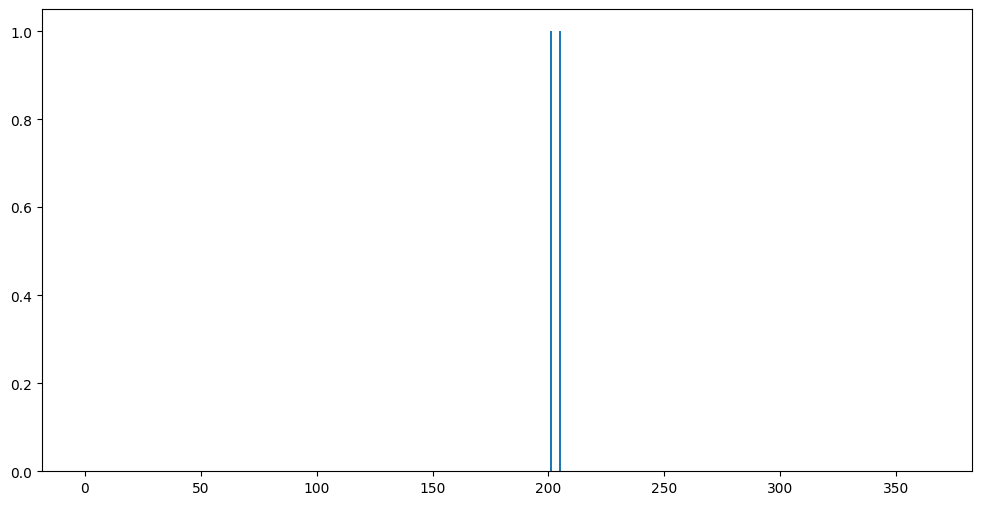

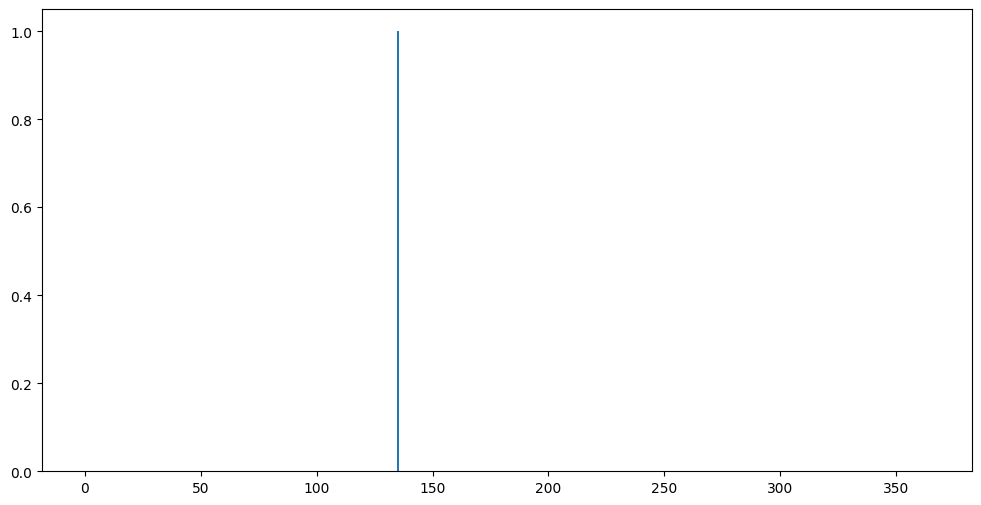

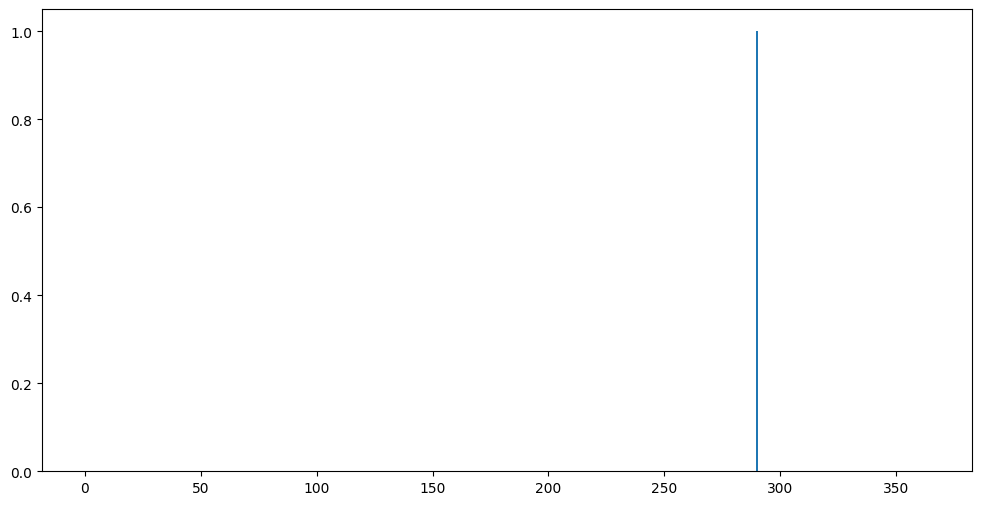

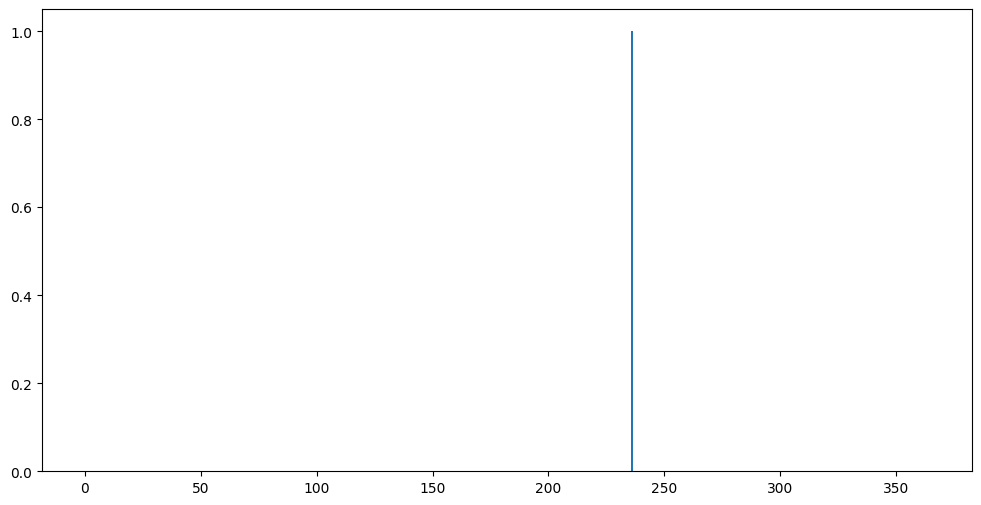

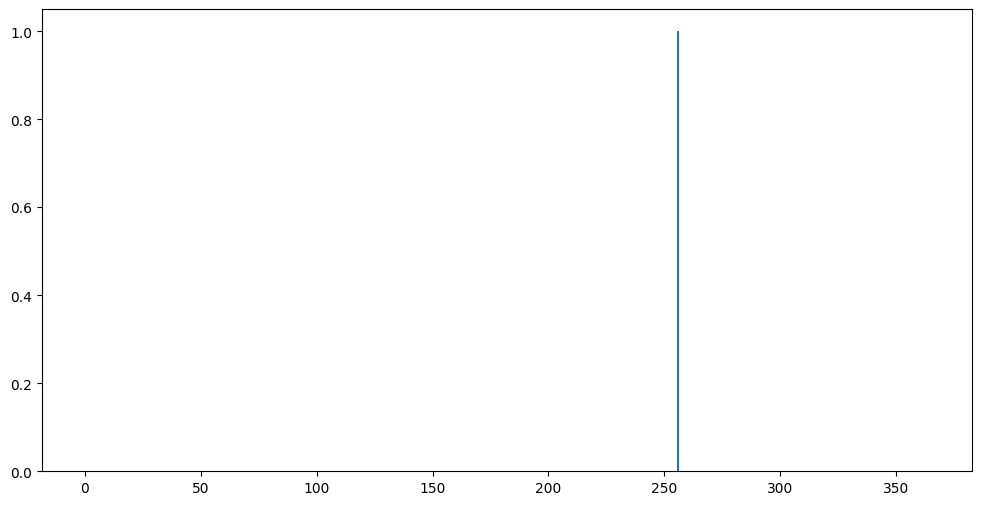

In [49]:
""" Modularizando o código de predição """

final_predictions = get_dataframe_predictions(clean_data, HYPERPARAMS)


In [55]:
final_predictions

{('1000423277513436210',
  '1164003957453133052'): tensor([-5.1048e-03, -2.4085e-03, -8.4244e-04, -3.4523e-03,  1.2534e-02,
         -1.3444e-03, -7.0442e-03, -5.8087e-03, -8.5704e-04,  4.2030e-03,
         -4.3917e-03,  1.3415e-02, -2.4255e-03, -6.3349e-03, -6.0464e-03,
         -2.0071e-03, -2.9535e-05, -4.1788e-03,  1.3132e-02,  1.4130e-04,
         -5.7500e-03, -3.4271e-03, -2.0669e-03,  2.4513e-03, -6.5755e-03,
          1.3404e-02, -2.6830e-03, -1.2874e-02], device='cuda:0',
        grad_fn=<CatBackward0>),
 ('1000423277513436210',
  '1870860275432322673'): tensor([-0.0100,  0.0002, -0.0026, -0.0099, -0.0160, -0.0047,  0.0022,  0.0083,
         -0.0031, -0.0177, -0.0133, -0.0149, -0.0071,  0.0043, -0.0091, -0.0001,
         -0.0049, -0.0090, -0.0153, -0.0063,  0.0020,  0.0094, -0.0084, -0.0117,
         -0.0139, -0.0181, -0.0091,  0.0029], device='cuda:0',
        grad_fn=<CatBackward0>),
 ('1000423277513436210',
  '2096630570628676364'): tensor([ 0.0009,  0.0011, -0.0085,  0.001

In [63]:
def forecast_to_output_2(predictions) -> pd.DataFrame:
    """
    Converte a previsão do modelo em um DataFrame formatado para submissão.
    
    Args:
        prediction (torch.Tensor): Tensor de previsão com shape (num_predictions, output_size).
        col_id (str): Identificador da coluna no formato 'produto_loja'.
        
    Returns:
        pd.DataFrame: DataFrame formatado com colunas ['semana', 'pdv', 'produto', 'quantidade'].
    """
    import math

    df_final = pd.DataFrame(columns=['semana', 'pdv', 'produto', 'quantidade'])
    df_final = df_final.astype({
        'semana': 'int32',
        'pdv': 'int32',
        'produto': 'int32',
        'quantidade': 'int32'
    })
    
    for key, value in predictions.items():
        product_id, store_id = key
        values = value.detach().cpu().numpy().flatten()

        weeks = []
        for i in range(0, len(values), 7):
            week_sum = values[i:i+7].sum()
            weeks.append(math.ceil(week_sum))

        # Crie o DataFrame final
        df_temp = pd.DataFrame({
            'semana': list(range(1, len(weeks) + 1)),
            'pdv': store_id,
            'produto': product_id,
            'quantidade': weeks
        })
        # Append to df_final
        df_final = pd.concat([df_final, df_temp], ignore_index=True)

    df_final.to_csv('submission.csv', index=False, sep=';', encoding='utf-8')
    return df_final

In [64]:
""" Output Formatting """

final_df = forecast_to_output_2(final_predictions)

In [65]:
final_df

,semana,pdv,produto,quantidade
0,1,1164003957453133052,1000423277513436210,0
1,2,1164003957453133052,1000423277513436210,0
2,3,1164003957453133052,1000423277513436210,0
3,4,1164003957453133052,1000423277513436210,0
4,1,1870860275432322673,1000423277513436210,0
5,2,1870860275432322673,1000423277513436210,0
6,3,1870860275432322673,1000423277513436210,0
7,4,1870860275432322673,1000423277513436210,0
8,1,2096630570628676364,1000423277513436210,0
9,2,2096630570628676364,1000423277513436210,0


# OLD

---

In [ ]:
""" Sampling and plotting - OK"""

sample = get_sample(clean_data, prediction_col)


# Transformando o Dataframe em um Dataset



In [ ]:
""" Rescaling e sampling - OK """

sample, feature = create_feature_rescale(sample)


In [ ]:
""" get dataset """

dataset_full, X, y = get_dataset(sample, feature, hyperparams)


# Separando os dados entre treino / validação

Os dados serão separados na proporção 80% - treino / 20% validação. Para séries temporais, é usual que essa separação seja feita de forma cronológica

In [ ]:
""" Separando treino e validação """

X_train, y_train, X_test, y_test, num_features = get_train_validation(dataset_full, X, y, hyperparams)


# Treinamento

In [ ]:
""" Training """

model = traininig_func(X_train, y_train, num_features, hyperparams)



# Sanity check do modelo treinado

In [ ]:
""" Sanity Check - TO-DO"""

# sanity_check_plot()

# ===

def sanity_check_plot(model, dataloader, device, output_size):
    """
    Plota previsões vs ground truth no período de treino
    """
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            preds = model(x)
            
            # Se seu modelo retorna (batch, output_size)
            preds = preds.cpu().numpy().flatten()
            y = y.cpu().numpy().flatten()

            all_preds.extend(preds)
            all_targets.extend(y)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(all_targets, label="Ground truth", linewidth=2)
    plt.plot(all_preds, label="Previsões", linewidth=2, alpha=0.7)
    plt.title("Sanity check - Previsões vs Ground Truth (treino)")
    plt.legend()
    plt.show()

sanity_check_plot(model, dataloader, device, output_size)

In [ ]:
y

# Validação do modelo

São feitos dois testes:

- **Soft test:** Modelo  tenta fazer as previsões, mas não utiliza-as nas previsões futuras, utiliza sempre os *ground truth* como input
- **Hard test:** Modelo tenta fazer as previsões, e utiliza $y_{i-1}$ para a previsão de $y_i$

In [ ]:
""" Model Validation - TO-DO """

# validate_model()

# ===

" Validando o modelo quando o split é menor que 1"
if split < 1:
    # Adotando o dataset de validação (soft)
    dataset = SingleSeriesDataset(X_test, y_test)
    dataloader = DataLoader(dataset, batch_size, shuffle=False) # shuffle=False para séries temporais

    all_preds_S, all_targets_S, avg_loss_test_S = soft_test(model, dataloader, device, criterion)

    # Validação hard - previsão cega das primeiras blind_horizon semanas
    all_preds_H, all_targets_H, avg_loss_test_H = hard_test(model, X_train, y_train, y_test, split_point, device, criterion, blind_horizon, output_size)

    " Sanity check da validação do modelo (preds and targets)"
    all_preds_array = []
    all_targets_array = []

    # Convert lists to tensors before flattening
    all_preds_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 1 else t for t in all_preds_H], dim=0).flatten()
    all_targets_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 1 else t for t in all_targets_H], dim=0).flatten()

    for t in all_preds_tensor:
        all_preds_array.append(t.detach().numpy())
    for t in all_targets_tensor:
        all_targets_array.append(t.detach().numpy())


    plt.figure(figsize=(12, 5))
    plt.plot(all_targets_array, label="Ground truth", linewidth=2)
    plt.plot(all_preds_array, label="Previsões", linewidth=2, alpha=0.7)
    plt.legend()


# Previsão cega (quando split == 1)

Previsão para envio para o hackathon das 4 primeiras semanas de janeiro/23. Utiliza todo o dataset como treino.

In [ ]:
""" Blind prediction """

blind_prediction = get_blind_prediction(model, X_train, hyperparams)


# Ponto de parada - RAB 18-09-25
- Temporais (mais fáceis de pensar e implementar)
- Categóricas (intrínsecas do produto ou da loja, como a categoria deles)
- De localização (apenas se der tempo)

Após termos feito isso, podemos então realizar normalização dos sinais, one hot encoding do que for viável e embedding de IDs etc